# Análise de preços de casas (índia)

Descrição da base de dados:

| **Coluna**          | **Descrição**                                                 |
| ------------------- | ------------------------------------------------------------- |
| **Index**             | Identificador único da linha no dataset.                      |
| **Title**             | Título do anúncio do imóvel.                                  |
| **Description**       | Descrição detalhada do imóvel.                                |
| **Amount(in rupees)** | Valor total do imóvel em rúpias.                              |
| **Price (in rupees)** | Preço por unidade de área (ex: por sqft) em rúpias.           |
| **location**          | Localização do imóvel (ex: cidade ou bairro).                 |
| **Carpet Area**       | Área útil interna do imóvel.                                  |\
| **Status**            | Estado do imóvel (ex: pronto para morar, em construção).      |
| **Floor**             | Andar onde o imóvel está localizado.                          |
| **Transaction**       | Tipo de transação (ex: revenda, nova).                        |
| **Furnishing**        | Nível de mobília (ex: mobiliado, semi, não mobiliado).        |
| **facing**            | Direção para a qual o imóvel está voltado (ex: leste, oeste). |
| **overlooking**       | Vista ou orientação do imóvel (ex: parque, rua).              |
| **Society**           | Nome do condomínio ou empreendimento.                         |
| **Bathroom**          | Quantidade de banheiros.                                      |
| **Balcony**           | Quantidade de varandas.                                       |
| **Car Parking**       | Tipo e quantidade de vagas de estacionamento.                 |
| **Ownership**         | Tipo de posse do imóvel (ex: freehold, co-operative).         |
| **Super Area**        | Área total construída do imóvel.                              |
| **Dimensions**        | Dimensões do imóvel (largura x comprimento).                  |
| **Plot Area**         | Área total do terreno do imóvel.                              |


# IMPORTS

In [68]:
# Manipulação de dados
import pandas as pd
import numpy as np
import re

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# pré-processamento/modelos/métricas
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, LinearRegression, ElasticNet, Perceptron
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Outros
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Download modelo
import joblib

# FUNÇÕES DE TRATAMENTO

In [7]:
# ===================== FUNÇÃO TRATAR MOEDA INDIANA =====================

def converter_india_to_num(texto):
    try:
        texto = str(texto).strip().lower()
        if 'lac' in texto:
            num = float(texto.replace('lac','').strip())
            return int(num * 100_000)
        elif 'cr' in texto:
            num = float(texto.replace('cr','').strip())
            return int(num * 10_000_000)
        else:
            return int(float(texto))
    except:
        return None



# ===================== FUNÇÃO TRATAR ANDARES =====================


def extrair_andar(valor):
    if pd.isna(valor):
        return pd.Series([np.nan, np.nan])

    valor = str(valor).lower().strip()

    nums = re.findall(r'\d+', valor)

    if 'ground' in valor:
        floor = 0
    elif 'basement' in valor:
        floor = -1
    else:
        floor = int(nums[0]) if nums else np.nan

    match = re.search(r'out of (\d+)', valor)
    if match:
        max_floors = int(match.group(1))
    elif nums:
        max_floors = int(nums[-1])
    else:
        max_floors = np.nan

    return pd.Series([floor, max_floors])




# ===================== FUNÇÃO PARA SUAVIZAR OUTLIERS =====================
def tratar_outliers(df_train, df_validation, col, max_limite=None):
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    if max_limite:
        limite_superior = min(limite_superior, max_limite)

    # Train
    df_train_filtrado = df_train[(df_train[col] >= limite_inferior) & (df_train[col] <= limite_superior)]

    # Validation
    df_validation_filtrado = df_validation[(df_validation[col] >= limite_inferior) & (df_validation[col] <= limite_superior)]

    return df_train_filtrado, df_validation_filtrado




# ===================== FUNÇÃO PARA TREINAR, TESTAR E AVALIAR MODELO =====================

def train_test_avaliate(model, x_train, x_test, y_train, y_test):
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  mae = mean_absolute_error(y_test, pred)
  rmse = root_mean_squared_error(y_test, pred)
  r2 = r2_score(y_test, pred)

  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R2: {r2:.2f}')

  return model




  # ===================== FUNÇÃO PARA TESTAR E AVALIAR MODELO EM VALIDAÇÃO =====================

def test_avaliate(model, x_val, y_val):
  pred = model.predict(x_val)

  mae = mean_absolute_error(y_val, pred)
  rmse = root_mean_squared_error(y_val, pred)
  r2 = r2_score(y_val, pred)

  print(f'MAE: {mae:.2f}')
  print(f'RMSE: {rmse:.2f}')
  print(f'R2: {r2:.2f}')

# CARREGANDO BASE DE DADOS

In [8]:
df = pd.read_csv(r'..\dados\house_prices.csv')

# ANÁLISE INICIAL

In [9]:
pd.set_option('display.max_columns', None)

display(df.head())
print('\n')
df.info()

,Index,Title,Description,Amount(in rupees),Price (in rupees),location,Carpet Area,Status,Floor,Transaction,Furnishing,facing,overlooking,Society,Bathroom,Balcony,Car Parking,Ownership,Super Area,Dimensions,Plot Area
0,0,1 BHK Ready to Occupy Flat for sale in Srushti...,"Bhiwandi, Thane has an attractive 1 BHK Flat f...",42 Lac,6000.0,thane,500 sqft,Ready to Move,10 out of 11,Resale,Unfurnished,NaN,NaN,Srushti Siddhi Mangal Murti Complex,1,2,NaN,NaN,NaN,NaN,NaN
1,1,2 BHK Ready to Occupy Flat for sale in Dosti V...,One can find this stunning 2 BHK flat for sale...,98 Lac,13799.0,thane,473 sqft,Ready to Move,3 out of 22,Resale,Semi-Furnished,East,Garden/Park,Dosti Vihar,2,NaN,1 Open,Freehold,NaN,NaN,NaN
2,2,2 BHK Ready to Occupy Flat for sale in Sunrise...,Up for immediate sale is a 2 BHK apartment in ...,1.40 Cr,17500.0,thane,779 sqft,Ready to Move,10 out of 29,Resale,Unfurnished,East,Garden/Park,Sunrise by Kalpataru,2,NaN,1 Covered,Freehold,NaN,NaN,NaN
3,3,1 BHK Ready to Occupy Flat for sale Kasheli,This beautiful 1 BHK Flat is available for sal...,25 Lac,NaN,thane,530 sqft,Ready to Move,1 out of 3,Resale,Unfurnished,NaN,NaN,NaN,1,1,NaN,NaN,NaN,NaN,NaN
4,4,2 BHK Ready to Occupy Flat for sale in TenX Ha...,"This lovely 2 BHK Flat in Pokhran Road, Thane ...",1.60 Cr,18824.0,thane,635 sqft,Ready to Move,20 out of 42,Resale,Unfurnished,West,"Garden/Park, Main Road",TenX Habitat Raymond Realty,2,NaN,1 Covered,Co-operative Society,NaN,NaN,NaN




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187531 entries, 0 to 187530
Data columns (total 21 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Index              187531 non-null  int64  
 1   Title              187531 non-null  object 
 2   Description        184508 non-null  object 
 3   Amount(in rupees)  187531 non-null  object 
 4   Price (in rupees)  169866 non-null  float64
 5   location           187531 non-null  object 
 6   Carpet Area        106858 non-null  object 
 7   Status             186916 non-null  object 
 8   Floor              180454 non-null  object 
 9   Transaction        187448 non-null  object 
 10  Furnishing         184634 non-null  object 
 11  facing             117298 non-null  object 
 12  overlooking        106095 non-null  object 
 13  Society            77853 non-null   object 
 14  Bathroom           186703 non-null  object 
 15  Balcony            138596 non-null  object 
 16  

Analisando os dados, observA-SE que as colunas `Dimensions` e `Plot Area`, estão com 100% dos valores nulos, o que impossibilita seu tratamento, logo, será necessário removê-las do conjunto de dados. Além disso, notei que algumas colunas que deveriam conter valores numéricos, como `Amount` e `Carpet Area`, apresentam strings misturadas aos números. Para realizar a conversão correta desses campos, será preciso efetuar um tratamento adequado dos dados antes da transformação.

In [10]:
# Dropnado colunas que não ajudarão
df.drop(columns=['Index', 'Title', 'Description', 'Society', 'Dimensions', 'Plot Area', 'Status'], inplace=True)

**Por que dropei cada coluna?**

- **Index:** É o índice das colunas, não ajudará em nada o modelo.
- **Title, Description e Society:** Além de serem muito diversificados, dificultando a tokenização, também não influenciam no preço.
- **Dimensions e Plot Area:** Os dados estão 100% nulos, não ajudará no modelo, provavelmente só o confundirá.
- **Status:** Todas as colunas só possuem um único valor, **Ready to Move**.


**Obs.:** Antes de iniciar o tratamento dos dados, irei dividir o conjunto em treino e validação logo no início, a fim de evitar data leakage (vazamento de dados).

# Dividindo os dados de treino e validação

In [11]:
# Dividindo os dados de treino e validação
df_train, df_validation = train_test_split(df, test_size=0.2, random_state=42)

In [12]:
print('Tamanho do df_train', df_train.shape)
print('Tamanho do df_validation', df_validation.shape)

Tamanho do df_train (150024, 14)
Tamanho do df_validation (37507, 14)


# INICIANDO O TRATAMENTO

Com os dados de treino e validação dividos, pode-se seguir com o tratamento de forma mais segura.

In [13]:
# Função para tratar 'amount'
# Train
df_train['Amount(in rupees)'] = df_train['Amount(in rupees)'].apply(converter_india_to_num)

# Validation
df_validation['Amount(in rupees)'] = df_validation['Amount(in rupees)'].apply(converter_india_to_num)

In [14]:
# Tratando 'Carpet Area' e 'Super Area'
# Train
df_train['Carpet Area'] = df_train['Carpet Area'].str.extract(r'(\d+)').astype('float64')
df_train['Super Area'] = df_train['Super Area'].str.extract(r'(\d+)').astype('float64')

# Validation
df_validation['Carpet Area'] = df_validation['Carpet Area'].str.extract(r'(\d+)').astype('float64')
df_validation['Super Area'] = df_validation['Super Area'].str.extract(r'(\d+)').astype('float64')

In [15]:
# Analisando 'andares'
df_train.Floor.value_counts(dropna=False)

Floor
2 out of 4      9980
1 out of 4      9602
3 out of 4      7030
1 out of 3      5719
NaN             5651
                ... 
28 out of 56       1
17 out of 36       1
17 out of 33       1
29 out of 33       1
16 out of 44       1
Name: count, Length: 916, dtype: int64

In [16]:
# Função para tratar andares
# Train
df_train[['Floor', 'max_floors']] = df_train['Floor'].apply(extrair_andar)

# Validation
df_validation[['Floor', 'max_floors']] = df_validation['Floor'].apply(extrair_andar)

In [17]:
# Tratando 'Car Parking'
# Train
df_train['Car Parking Type'] = df_train['Car Parking'].str.extract(r'\d+\s*(.*)')
df_train['Car Parking'] = df_train['Car Parking'].str.extract(r'(\d+)').astype('float64')

# Validation
df_validation['Car Parking Type'] = df_validation['Car Parking'].str.extract(r'\d+\s*(.*)')
df_validation['Car Parking'] = df_validation['Car Parking'].str.extract(r'(\d+)').astype('float64')

In [18]:
df_train['Car Parking Type'].value_counts()

Car Parking Type
Covered     41164
Covered,    16927
Open         9230
Name: count, dtype: int64

In [19]:
# Tirando a virgula
# Train
df_train['Car Parking Type'] = df_train['Car Parking Type'].str.replace(',', '')

# Validation
df_validation['Car Parking Type'] = df_validation['Car Parking Type'].str.replace(',', '')

In [20]:
# Tratando 'Balcony' > 10
# Train
df_train['Balcony'] = df_train['Balcony'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

# Validation
df_validation['Balcony'] = df_validation['Balcony'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

In [21]:
# Tratando 'Bathroom' > 10
# Train
df_train['Bathroom'] = df_train['Bathroom'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

# Validation
df_validation['Bathroom'] = df_validation['Bathroom'].apply(lambda x: 11 if x == '> 10' else x).astype('float64')

Considerando que os dados já estão devidamente formatados, podemos analisar os numeros nulos e trata-los também.

In [22]:
# Verificando nulos
df_train.isna().sum()

Amount(in rupees)     7780
Price (in rupees)    14094
location                 0
Carpet Area          64648
Floor                 5651
Transaction             66
Furnishing            2336
facing               56145
overlooking          65078
Bathroom               656
Balcony              39116
Car Parking          82703
Ownership            52300
Super Area           86055
max_floors            5654
Car Parking Type     82703
dtype: int64

In [23]:
# Preenchendo com a mediana
cols = ['Amount(in rupees)', 'Price (in rupees)']

# Loop para preencher nulos usando o modo do train
for col in cols:
    # Train
    df_train[col] = df_train[col].fillna(df_train[col].median())

    # Validation
    df_validation[col] = df_validation[col].fillna(df_train[col].median())


In [24]:
# Preenchendo com a moda
cols = ['Bathroom', 'Furnishing', 'Floor', 'max_floors']

# Loop para preencher nulos usando o modo do train
for col in cols:
    # Train
    df_train[col] = df_train[col].fillna(df_train[col].mode()[0])

    # Validation
    df_validation[col] = df_validation[col].fillna(df_train[col].mode()[0])


In [25]:
# Preenchendo com 'Not Informed'
cols = ['facing', 'overlooking', 'Car Parking Type', 'Ownership', 'Transaction']

# Train
df_train[cols] = df_train[cols].fillna('Not Informed')

# Validation
df_validation[cols] = df_validation[cols].fillna('Not Informed')

In [26]:
# Preenhcendo com 0
cols = ['Balcony', 'Car Parking']

# Train
df_train[cols] = df_train[cols].fillna(0)

# Validation
df_validation[cols] = df_validation[cols].fillna(0)

In [27]:
# Preenchendo pela mediana agrupada por 'location' (para não distorcer a veracidade dos valores)
cols = ['Carpet Area', 'Super Area']
df_train[cols] = df_train.groupby('location')[cols].transform(lambda x: x.fillna(x.median()))

# Calcula as medianas no train
medianas = df_train.groupby('location')[cols].median()

# Preenche no validation
for col in cols:
    df_validation[col] = df_validation['location'].map(medianas[col]).combine_first(df_validation[col])

onsiderando que os dados nulos estão devidamente tratados, podemos verificar como ficou a distribuição dos dados e verificar outliers.

In [28]:
df_train.describe().round()

,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors
count,1.500240e+05,150024.0,150024.0,150024.0,150024.0,150024.0,150024.0,150024.0,150024.0
mean,1.176040e+07,7450.0,1125.0,4.0,2.0,1.0,2.0,1176.0,9.0
std,4.032342e+07,26956.0,2467.0,5.0,1.0,1.0,21.0,536.0,8.0
min,1.000000e+05,0.0,1.0,-1.0,1.0,0.0,0.0,1.0,1.0
25%,5.000000e+06,4509.0,780.0,2.0,2.0,0.0,0.0,900.0,4.0
50%,7.800000e+06,6034.0,1000.0,3.0,2.0,1.0,0.0,1225.0,5.0
75%,1.360000e+07,8487.0,1300.0,5.0,3.0,2.0,1.0,1416.0,11.0
max,1.400300e+10,6700000.0,709222.0,200.0,11.0,11.0,999.0,9450.0,200.0


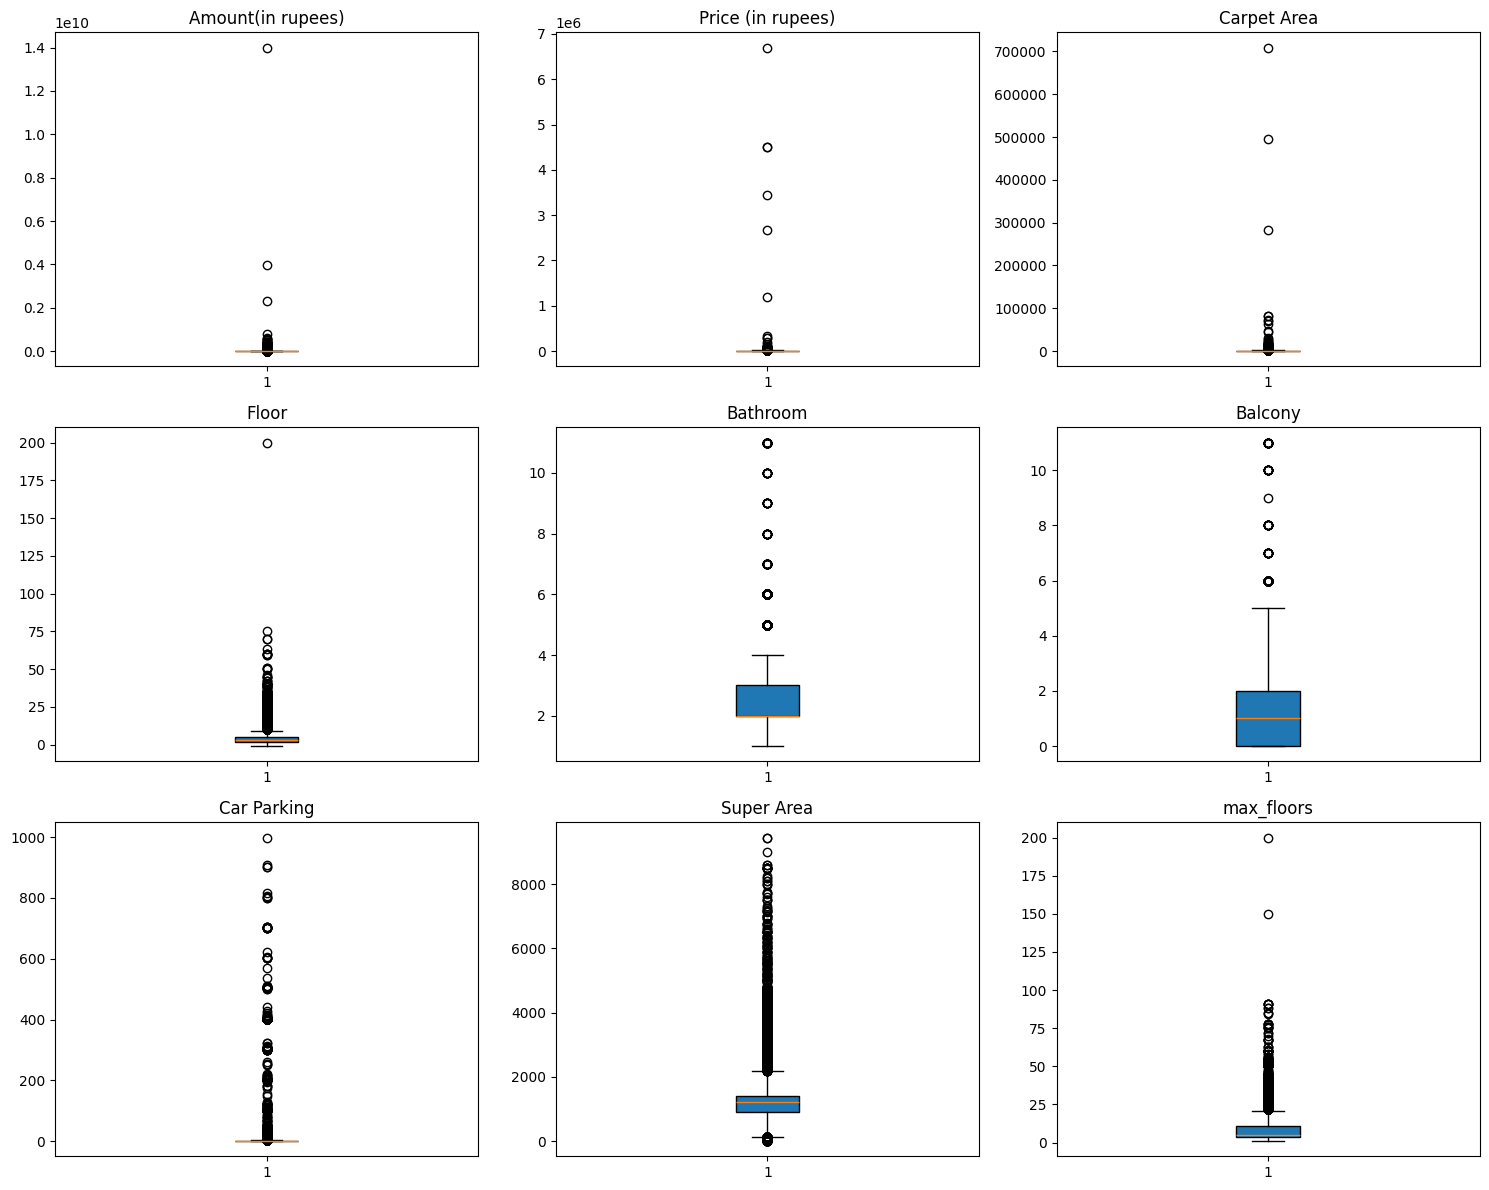

In [29]:
# Boxplots plots
num_cols = df_train.select_dtypes(include=['int64', 'float64']).columns

n_cols = 3
n_rows = (len(num_cols) + n_cols - 1) // n_cols
plt.figure(figsize=(15, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(df_train[col].dropna(), patch_artist=True)
    plt.title(col)
    plt.tight_layout()

plt.show()


In [30]:
cols = {
    'Amount(in rupees)': 15_000_000_0,
    'Carpet Area': 10_000,
    'Super Area': 12_000,
    'Floor': 100,
    'Car Parking': 20
}

# Itera pela lista e aplica a função em ambos os dataframes
for coluna, limite in cols.items():
    df_train, df_validation = tratar_outliers(
        df_train,
        df_validation,
        coluna,
        max_limite=limite
    )

print(f"Formato df_train após remoção de outliers: {df_train.shape}")
print(f"Formato df_validation após remoção de outliers: {df_validation.shape}")

Formato df_train após remoção de outliers: (111661, 16)
Formato df_validation após remoção de outliers: (29886, 16)


# TÉCNICA PARA SUAVIZAR OS DADOS

Considerando que os dados numéricos tinham muitos ouliers, resolvi aplicar uma técnica para suavizar esses valores extremos, fazendo assim, com que o modelo tenha uma melhor aprendizagem sobre os dados.

C:\Users\carlo\AppData\Local\Temp\ipykernel_17916\65000957.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='viridis')


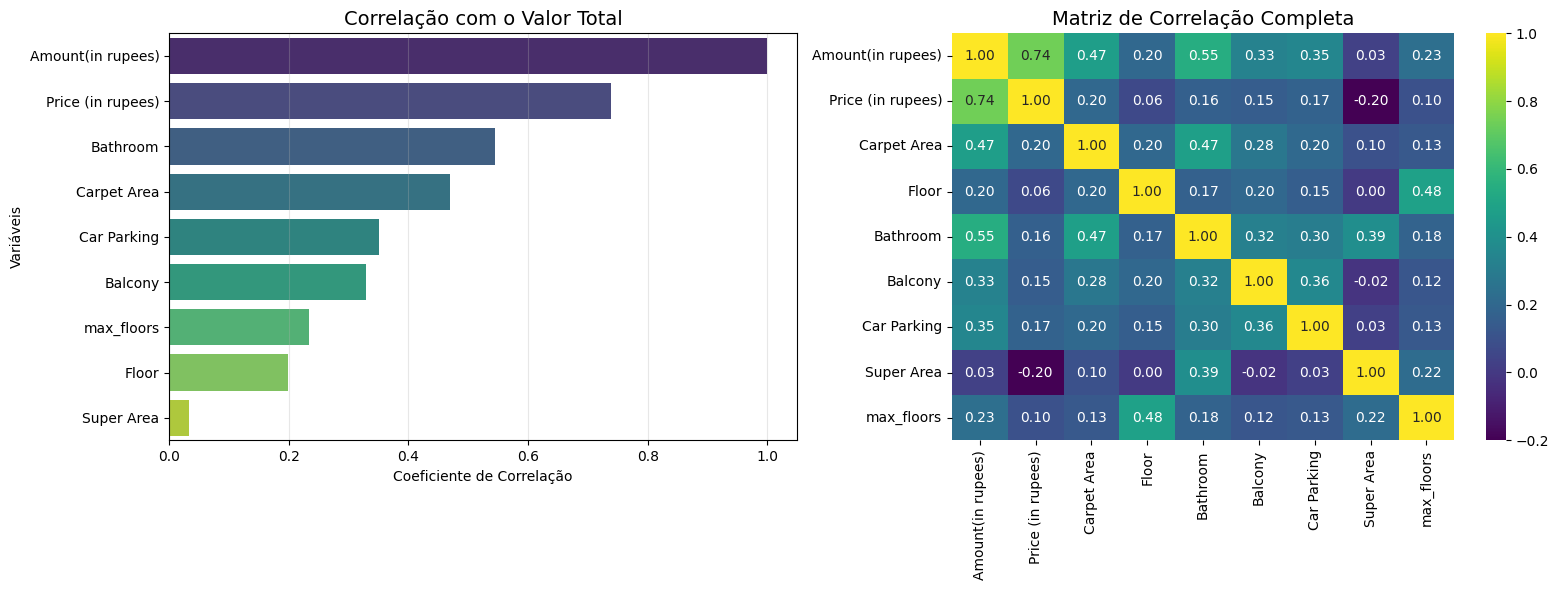

In [31]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64'])
correlacoes = numeric_cols.corr()['Amount(in rupees)'].sort_values(ascending=False)
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
sns.barplot(x=correlacoes.values, y=correlacoes.index, palette='viridis')
plt.title('Correlação com o Valor Total', fontsize=14)
plt.xlabel('Coeficiente de Correlação')
plt.ylabel('Variáveis')
plt.grid(axis='x', alpha=0.3)

plt.subplot(1, 2, 2)
sns.heatmap(numeric_cols.corr(), cmap='viridis', annot=True, fmt='.2f')
plt.title('Matriz de Correlação Completa', fontsize=14)

plt.tight_layout()
plt.show()


Considerando a análise das correlações, consegui verificar que não há correlacões muito fortes, porém, existe correlação.

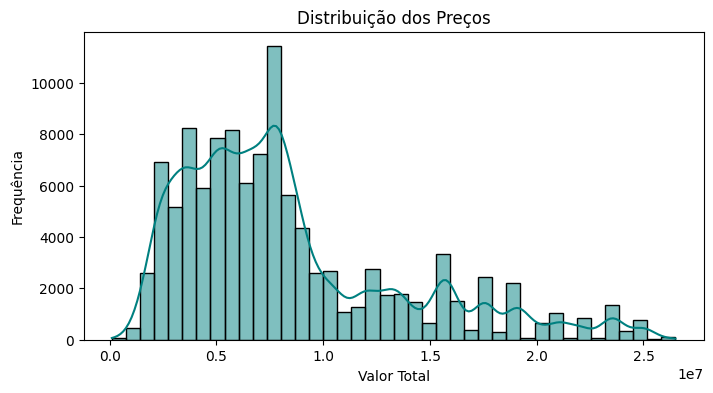

In [32]:
# Distribuição de Amount
plt.figure(figsize=(8,4))
sns.histplot(df_train['Amount(in rupees)'], bins=40, kde=True, color='teal')
plt.title('Distribuição dos Preços')
plt.xlabel('Valor Total')
plt.ylabel('Frequência')
plt.show()

Os valores são bem variádos, porém é possível ver que a maioria das propriedades esstão em torno de 6000 rúpias.

C:\Users\carlo\AppData\Local\Temp\ipykernel_17916\876310716.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=media_preco.values, y=media_preco.index, palette='viridis')


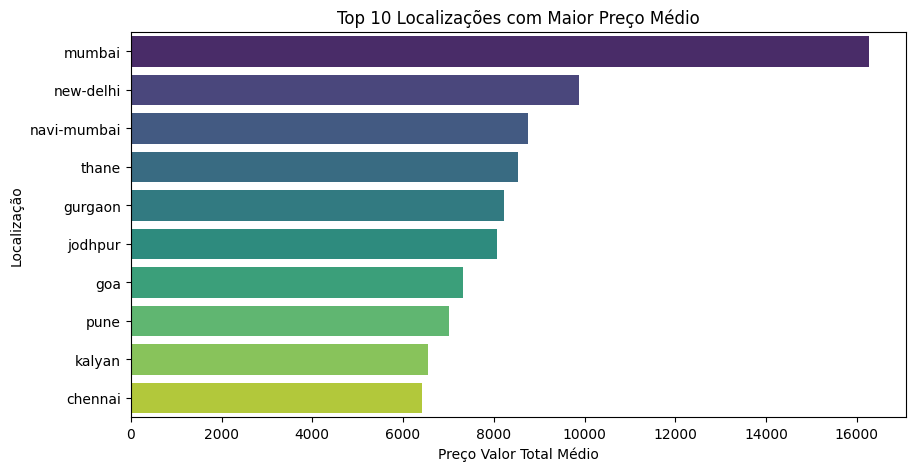

In [33]:
# Preço por localização
plt.figure(figsize=(10,5))
media_preco = df_train.groupby('location')['Price (in rupees)'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=media_preco.values, y=media_preco.index, palette='viridis')
plt.title('Top 10 Localizações com Maior Preço Médio')
plt.xlabel('Preço Valor Total Médio')
plt.ylabel('Localização')
plt.show()


C:\Users\carlo\AppData\Local\Temp\ipykernel_17916\4258338958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_train, y='location', order=df_train['location'].value_counts().index[:10], palette='viridis')


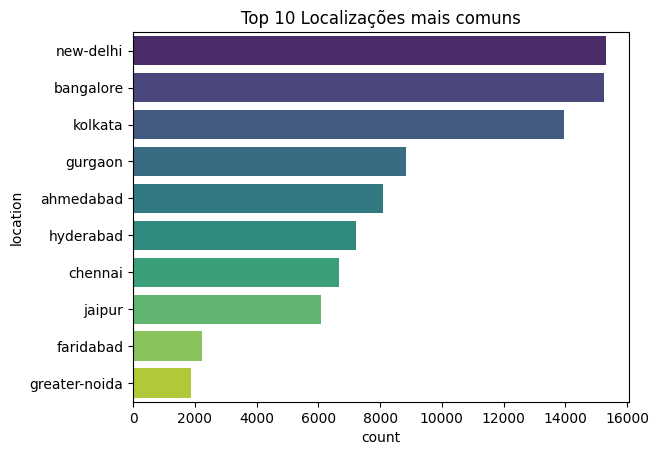

In [34]:
sns.countplot(data=df_train, y='location', order=df_train['location'].value_counts().index[:10], palette='viridis')
plt.title('Top 10 Localizações mais comuns')
plt.show()

Analisando os gráficos sobre localização, é interessante ver que **bangalore** é o lugar onde os preços são menores, porém é onde é mais popular, ou seja, onde há mais vendas. Já **new-delhi** é a segunda mais popular e a primeira mais cara.

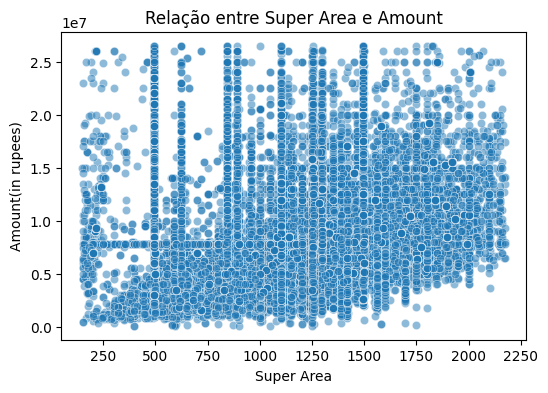

In [35]:
# Correlação entre Area e Amount
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_train, x='Super Area', y='Amount(in rupees)', alpha=0.5)
plt.title('Relação entre Super Area e Amount')
plt.xlabel('Super Area')
plt.ylabel('Amount(in rupees)')
plt.show()


O gráficos de correlação entre área e preço, mostra que não há uma linearidade muito forte entre elas, afirmande o que foi mostrado no gráfico "Correlação com preço" quanto no gráfico "Matriz de correlação completa".

C:\Users\carlo\AppData\Local\Temp\ipykernel_17916\2693955900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_train, x='Furnishing', y='Amount(in rupees)', estimator='mean', palette='magma', errorbar=None)


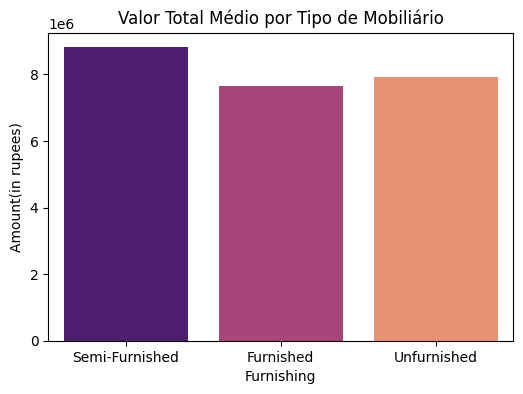

In [36]:
# Valor Total por tipo mobiliario
plt.figure(figsize=(6,4))
sns.barplot(data=df_train, x='Furnishing', y='Amount(in rupees)', estimator='mean', palette='magma', errorbar=None)
plt.title('Valor Total Médio por Tipo de Mobiliário')
plt.show()


Já no valor total médio por tipo mobiliário, vemos que não há uma disparidade tão grande. São todas bem distribuidas. Porém, os valores são maiores geralmente são maiores nas propriedades semi-mobiliadas.

Olhando mais afundo sobre os dados, e verificando de forma mais visual, posso seguir agora com a transformação dos dados categoricos para numéricos, para assim, poder prosseguir com o modelo preditivo.

In [38]:
# Salvando dados tratados
df_train.to_csv('df_train.csv', index=False)
df_validation.to_csv('df_validation.csv', index=False)

# PRÉ-PROCESSAMENTO

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 111661 entries, 151915 to 121958
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Amount(in rupees)  111661 non-null  float64
 1   Price (in rupees)  111661 non-null  float64
 2   location           111661 non-null  object 
 3   Carpet Area        111661 non-null  float64
 4   Floor              111661 non-null  float64
 5   Transaction        111661 non-null  object 
 6   Furnishing         111661 non-null  object 
 7   facing             111661 non-null  object 
 8   overlooking        111661 non-null  object 
 9   Bathroom           111661 non-null  float64
 10  Balcony            111661 non-null  float64
 11  Car Parking        111661 non-null  float64
 12  Ownership          111661 non-null  object 
 13  Super Area         111661 non-null  float64
 14  max_floors         111661 non-null  float64
 15  Car Parking Type   111661 non-null  object 
dtypes:

Para a tranformação desses dados, utilizarei **get_dummies** do pandas, que é essencial para utilizar em modelos de regressão.

**Obs.:** Na coluna `location` irei pegar as top 20 localizações, pois, ela possue muitos dados distintos, gerando muitas colunas se get_dummies for aplicado. Então reduzirei ela.

In [42]:
# Seleciona top 20 locations e o resto vira 'Other'
top_locations = df_train['location'].value_counts().nlargest(20).index

# Train
df_train['location_grouped'] = df_train['location'].apply(lambda x: x if x in top_locations else 'Other')

# Validation
df_validation['location_grouped'] = df_validation['location'].apply(lambda x: x if x in top_locations else 'Other')

In [43]:
# Encodando com get_dummies
cols = [col for col in df_train.select_dtypes(include=['object']).columns]

# Train
df_train_encoded = pd.get_dummies(df_train, columns=cols, drop_first=False)

# Validation
df_validation_encoded = pd.get_dummies(df_validation, columns=cols, drop_first=False)
df_validation_encoded = df_validation_encoded.reindex(columns=df_train_encoded.columns, fill_value=0)

In [44]:
print('df_train_encoded')
display(df_train_encoded.head())

print('\ndf_validation_encoded')
display(df_validation_encoded.head())

df_train_encoded


,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors,location_agra,location_ahmadnagar,location_ahmedabad,location_allahabad,location_aurangabad,location_badlapur,location_bangalore,location_belgaum,location_bhiwadi,location_bhiwandi,location_bhopal,location_bhubaneswar,location_chandigarh,location_chennai,location_coimbatore,location_dehradun,location_durgapur,location_ernakulam,location_faridabad,location_ghaziabad,location_goa,location_greater-noida,location_guntur,location_gurgaon,location_guwahati,location_gwalior,location_haridwar,location_hyderabad,location_indore,location_jabalpur,location_jaipur,location_jamshedpur,location_jodhpur,location_kalyan,location_kanpur,location_kochi,location_kolkata,location_kozhikode,location_lucknow,location_ludhiana,location_madurai,location_mangalore,location_mohali,location_mumbai,location_mysore,location_nagpur,location_nashik,location_navi-mumbai,location_navsari,location_nellore,location_new-delhi,location_noida,location_palakkad,location_palghar,location_panchkula,location_patna,location_pondicherry,location_pune,location_raipur,location_rajahmundry,location_ranchi,location_satara,location_shimla,location_siliguri,location_solapur,location_sonipat,location_surat,location_thane,location_thrissur,location_tirupati,location_trichy,location_trivandrum,location_udaipur,location_udupi,location_vadodara,location_vapi,location_varanasi,location_vijayawada,location_visakhapatnam,location_vrindavan,location_zirakpur,Transaction_New Property,Transaction_Not Informed,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_East,facing_North,facing_North - East,facing_North - West,facing_Not Informed,facing_South,facing_South - East,facing_South -West,facing_West,overlooking_Garden/Park,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Not Available","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Informed,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park","overlooking_Pool, Main Road, Not Available",Ownership_Co-operative Society,Ownership_Freehold,Ownership_Leasehold,Ownership_Not Informed,Ownership_Power Of Attorney,Car Parking Type_Covered,Car Parking Type_Not Informed,Car Parking Type_Open,location_grouped_Other,location_grouped_ahmedabad,location_grouped_bangalore,location_grouped_chandigarh,location_grouped_chennai,location_grouped_dehradun,location_grouped_faridabad,location_grouped_greater-noida,location_grouped_gurgaon,location_grouped_hyderabad,location_grouped_jaipur,location_grouped_kolkata,location_grouped_mohali,location_grouped_new-delhi,location_grouped_pune,location_grouped_ranchi,location_grouped_surat,location_grouped_thane,location_grouped_vadodara,location_grouped_visakhapatnam,location_grouped_zirakpur
151915,7590000.0,3941.0,1390.0,4.0,3.0,4.0,1.0,1600.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,Fals


df_validation_encoded


,Amount(in rupees),Price (in rupees),Carpet Area,Floor,Bathroom,Balcony,Car Parking,Super Area,max_floors,location_agra,location_ahmadnagar,location_ahmedabad,location_allahabad,location_aurangabad,location_badlapur,location_bangalore,location_belgaum,location_bhiwadi,location_bhiwandi,location_bhopal,location_bhubaneswar,location_chandigarh,location_chennai,location_coimbatore,location_dehradun,location_durgapur,location_ernakulam,location_faridabad,location_ghaziabad,location_goa,location_greater-noida,location_guntur,location_gurgaon,location_guwahati,location_gwalior,location_haridwar,location_hyderabad,location_indore,location_jabalpur,location_jaipur,location_jamshedpur,location_jodhpur,location_kalyan,location_kanpur,location_kochi,location_kolkata,location_kozhikode,location_lucknow,location_ludhiana,location_madurai,location_mangalore,location_mohali,location_mumbai,location_mysore,location_nagpur,location_nashik,location_navi-mumbai,location_navsari,location_nellore,location_new-delhi,location_noida,location_palakkad,location_palghar,location_panchkula,location_patna,location_pondicherry,location_pune,location_raipur,location_rajahmundry,location_ranchi,location_satara,location_shimla,location_siliguri,location_solapur,location_sonipat,location_surat,location_thane,location_thrissur,location_tirupati,location_trichy,location_trivandrum,location_udaipur,location_udupi,location_vadodara,location_vapi,location_varanasi,location_vijayawada,location_visakhapatnam,location_vrindavan,location_zirakpur,Transaction_New Property,Transaction_Not Informed,Transaction_Other,Transaction_Rent/Lease,Transaction_Resale,Furnishing_Furnished,Furnishing_Semi-Furnished,Furnishing_Unfurnished,facing_East,facing_North,facing_North - East,facing_North - West,facing_Not Informed,facing_South,facing_South - East,facing_South -West,facing_West,overlooking_Garden/Park,"overlooking_Garden/Park, Main Road","overlooking_Garden/Park, Main Road, Pool","overlooking_Garden/Park, Not Available","overlooking_Garden/Park, Pool","overlooking_Garden/Park, Pool, Main Road","overlooking_Garden/Park, Pool, Main Road, Not Available",overlooking_Main Road,"overlooking_Main Road, Garden/Park","overlooking_Main Road, Garden/Park, Pool","overlooking_Main Road, Not Available","overlooking_Main Road, Pool","overlooking_Main Road, Pool, Garden/Park",overlooking_Not Informed,overlooking_Pool,"overlooking_Pool, Garden/Park","overlooking_Pool, Garden/Park, Main Road","overlooking_Pool, Main Road","overlooking_Pool, Main Road, Garden/Park","overlooking_Pool, Main Road, Not Available",Ownership_Co-operative Society,Ownership_Freehold,Ownership_Leasehold,Ownership_Not Informed,Ownership_Power Of Attorney,Car Parking Type_Covered,Car Parking Type_Not Informed,Car Parking Type_Open,location_grouped_Other,location_grouped_ahmedabad,location_grouped_bangalore,location_grouped_chandigarh,location_grouped_chennai,location_grouped_dehradun,location_grouped_faridabad,location_grouped_greater-noida,location_grouped_gurgaon,location_grouped_hyderabad,location_grouped_jaipur,location_grouped_kolkata,location_grouped_mohali,location_grouped_new-delhi,location_grouped_pune,location_grouped_ranchi,location_grouped_surat,location_grouped_thane,location_grouped_vadodara,location_grouped_visakhapatnam,location_grouped_zirakpur
99649,12000000.0,9646.0,780.0,2.0,2.0,0.0,1.0,1100.0,4.0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,0,False,False,0,True

## MODELOS:

- PREDITIVO
- CLASSIFICAÇÃO

In [47]:
# Divisão features -> target
x = df_train_encoded.drop(columns=['Amount(in rupees)', 'Price (in rupees)'])
y = df_train_encoded[['Amount(in rupees)']]

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
# Função para treinar, testar e avaliar modelo

lr = LinearRegression()

lr_trained = train_test_avaliate(lr, x_train, x_test, y_train, y_test)

MAE: 2272686.82
RMSE: 3052457.66
R2: 0.67


In [ ]:
# Função para treinar, testar e avaliar modelo

# Normalização (essencial para redes neurais)
scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Configuração do Perceptron para regressão
mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50),   # duas camadas ocultas com 50 neurônios cada
    activation='relu',             # ativação nas camadas ocultas
    solver='adam',                 # otimizador
    learning_rate_init=0.01,       # taxa de aprendizado
    max_iter=1000,                 # número máximo de iterações
    random_state=42
)

pc_trained = train_test_avaliate(mlp, x_train, x_test, y_train, y_test)

MAE: 1136844.94
RMSE: 1835782.66
R2: 0.88


# VALIDAÇÃO INICIAL

In [64]:
# Divisão dos dados de validação
x_val = df_validation_encoded.drop(columns=['Amount(in rupees)', 'Price (in rupees)'])
y_val = df_validation_encoded[['Amount(in rupees)']]

In [ ]:
# função para fazer a previsão e avaliar o modelo
test_avaliate(mlp, x_val, y_val)

MAE: 2606384.83
RMSE: 3857838.35
R2: 0.51


In [ ]:
test_avaliate(mlp, x_val, y_val)

# TREINO GERAL COM VARIAÇÃO DE PARÂMETROS

In [93]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor

def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    start = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    elapsed = time.time() - start

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)       # sem 'squared'
    rmse = np.sqrt(mse)                            # RMSE = sqrt(MSE)
    r2 = r2_score(y_test, y_pred)

    return {
        "Algoritmo": name,
        "Configuração": str(model.get_params()),
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2,
        "Tempo (s)": elapsed
    }

# exemplos de modelos
linear_models = [
    LinearRegression(),
    LinearRegression(fit_intercept=False),
    Ridge(alpha=1.0)
]

mlp_models = [
    MLPRegressor(hidden_layer_sizes=(20,), max_iter=300, random_state=42),
    MLPRegressor(hidden_layer_sizes=(10,50), max_iter=100, random_state=42),
    MLPRegressor(hidden_layer_sizes=(50,50), activation='tanh', solver='sgd', max_iter=800, random_state=42)
]

# avalia e cria tabela
results = []
for model in linear_models + mlp_models:
    results.append(evaluate_model(model, x_train, x_test, y_train, y_test, type(model).__name__))

df_results = pd.DataFrame(results)
print(df_results)


          Algoritmo                                       Configuração  \
0  LinearRegression  {'copy_X': True, 'fit_intercept': True, 'n_job...   
1  LinearRegression  {'copy_X': True, 'fit_intercept': False, 'n_jo...   
2             Ridge  {'alpha': 1.0, 'copy_X': True, 'fit_intercept'...   
3      MLPRegressor  {'activation': 'relu', 'alpha': 0.0001, 'batch...   
4      MLPRegressor  {'activation': 'relu', 'alpha': 0.0001, 'batch...   
5      MLPRegressor  {'activation': 'tanh', 'alpha': 0.0001, 'batch...   

            MAE          RMSE        R²   Tempo (s)  
0  2.272687e+06  3.052458e+06  0.665633    1.300595  
1  2.272708e+06  3.052502e+06  0.665623    1.077648  
2  2.272569e+06  3.052439e+06  0.665637    0.199049  
3  3.209709e+06  4.254749e+06  0.350361  128.773701  
4  2.735413e+06  3.676524e+06  0.514936   37.377831  
5  4.039017e+06  5.278844e+06 -0.000004    8.157305  


# Resultado

## MLPRegressor:
- A configuração com duas camadas ocultas e ativação ReLU teve o melhor desempenho (R² = 0.51).
- Outras configurações com tanh ou redes mais rasas tiveram desempenho inferior.
- O tempo de execução varia bastante: redes mais profundas são mais lentas.

## Regressão Linear:
- Todos os modelos lineares (com ou sem intercepto, e Ridge) tiveram desempenho praticamente idêntico.
-R² ≈ 0.6566 mostra que eles explicam bem os dados, com tempo de execução muito baixo.


# VALIDAÇÃO GERAL

In [94]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor

# Função para avaliar em validação
def test_avaliatee(model, x_val, y_val):
    y_pred = model.predict(x_val)
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    print("=== Avaliação em Validação ===")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

# Avaliação em treino/teste
results = []
for model in linear_models + mlp_models:
    results.append(test_avaliatee(model, x_val, y_val))

df_results = pd.DataFrame(results)
print(df_results)

=== Avaliação em Validação ===
MAE: 2825012.29
RMSE: 3863347.96
R²: 0.51
=== Avaliação em Validação ===
MAE: 2824947.86
RMSE: 3863317.77
R²: 0.51
=== Avaliação em Validação ===
MAE: 2824642.69
RMSE: 3862838.82
R²: 0.51
=== Avaliação em Validação ===
MAE: 3853658.92
RMSE: 5032404.49
R²: 0.17
=== Avaliação em Validação ===
MAE: 3357803.38
RMSE: 4518529.38
R²: 0.33
=== Avaliação em Validação ===
MAE: 4208797.85
RMSE: 5528389.98
R²: -0.00
      0
0  None
1  None
2  None
3  None
4  None
5  None


# Resultado

## MLPRegressor:
- A configuração com duas camadas ocultas e ativação ReLU teve o melhor desempenho (R² = 0.51).
- Outras configurações com tanh ou redes mais rasas tiveram desempenho inferior.

## Regressão Linear:
- O modelo com intercepto teve desempenho equivalente ao melhor MLP.
- Ridge não trouxe ganhos significativos, mas manteve estabilidade.


# Conclusão

Ao longo deste projeto, trabalhei com um grande conjunto de dados do mercado imobiliário indiano, que exigiu um processo detalhado de preparação antes da aplicação dos modelos de aprendizado de máquina. Foi necessário converter valores monetários, tratar variáveis textuais e categóricas, lidar com valores nulos e remover outliers para que os dados se tornassem consistentes e adequados à modelagem. Esse trabalho de pré‑processamento foi fundamental para garantir que os algoritmos pudessem aprender de forma mais eficiente e produzir resultados confiáveis.

Na etapa de modelagem, utilizei tanto algoritmos lineares quanto redes neurais. A regressão linear, em suas diferentes configurações (com intercepto, sem intercepto e com regularização Ridge), apresentou resultados muito próximos entre si, com R² em torno de 0.66. Isso mostra que os modelos lineares foram capazes de explicar boa parte da variabilidade dos preços, além de terem a vantagem de serem rápidos e estáveis. Já o MLPRegressor, em sua melhor configuração com duas camadas ocultas e ativação ReLU, alcançou R² ≈ 0.51, mostrando desempenho inferior ao linear, mas ainda relevante. Outras configurações de MLP tiveram resultados mais fracos, inclusive com R² próximo de zero, o que evidencia a sensibilidade desse tipo de modelo às escolhas de arquitetura e hiperparâmetros.

Na validação, os resultados mostraram que tanto a regressão linear quanto o MLP com ReLU tiveram desempenho semelhante, com R² ≈ 0.51. Isso reforça que, para este conjunto de dados, modelos lineares simples podem ser tão eficazes quanto redes neurais mais complexas, além de serem mais rápidos e menos custosos computacionalmente. Apesar disso, os erros absolutos ainda se mantiveram elevados, o que reflete a grande variabilidade dos preços de imóveis e a dificuldade de capturar todos os fatores que influenciam o mercado.

Portanto, este projeto demonstrou que é possível prever preços de imóveis com precisão moderada, mas também evidenciou limitações importantes. A alta diversidade das variáveis categóricas, a presença de outliers e a complexidade do mercado imobiliário tornam o problema desafiador. Como próximos passos, considero essencial explorar algoritmos mais robustos, como Random Forest ou XGBoost, além de investir em engenharia de atributos, criando variáveis derivadas como preço por metro quadrado ou agrupando localizações em categorias mais representativas. Também vejo valor em aplicar validação cruzada e ajuste fino de hiperparâmetros para melhorar a generalização dos modelos.

Em síntese, o projeto cumpriu seu objetivo de comparar diferentes abordagens de regressão e mostrou que, mesmo em cenários complexos, a regressão linear continua sendo uma solução eficiente e competitiva. A experiência reforça a importância do pré‑processamento e da avaliação rigorosa em validação, além de abrir caminho para futuras melhorias que podem elevar a qualidade das previsões e tornar os modelos ainda mais úteis para aplicações reais no mercado imobiliário.